In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimDataset
from unsupervised_loss import UnsupervisedLoss


import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel
from math import sqrt
import scprep

from torch_geometric.data import Data

In [2]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

Transforming to str index.
Processing...
data/5_backbone/bifurcating_3_1_1_100
Normalized count data: X, spliced, unspliced.
computing neighbors
Transforming to str index.
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
data/5_backbone/bifurcating_3_1_1_150
Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity',

60

In [3]:
dataset[0].adj[0].shape

(100,)

In [4]:
t = np.arange(2,15)
# dataset for training
train_mask = list(t) + list(t+15) + list(t+30) + list(t+45)
# dataset for validation
val_mask = [0,1,15,16,30,31,45,46]


In [5]:
def train(train_loader):
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label))
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred = model(data).detach().cpu().numpy().reshape(-1)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [6]:
dataset = RnaVeloDataset(root='data/')
batch_size = 1
# mask the dataset
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GraphSAGEModel(dataset.num_features, device).to(device)
model = FCModel(dataset.num_features, device).to(device)

# reset parameters
model.reset_parameters()
print(model)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-4, weight_decay=0.01)

train_list = []
val_list = []
for epoch in range(501):
    train_loss = train(train_loader)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)
    # print(train_loss)

FCModel(
  (lin1): Linear(in_features=70, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)
Epoch: 000, Loss: 0.2855, Train: 0.2465, Val: 0.2523
Epoch: 010, Loss: 0.1034, Train: 0.1060, Val: 0.1335
Epoch: 020, Loss: 0.0910, Train: 0.0950, Val: 0.1301
Epoch: 030, Loss: 0.0851, Train: 0.0901, Val: 0.1305
Epoch: 040, Loss: 0.0817, Train: 0.0853, Val: 0.1271
Epoch: 050, Loss: 0.0786, Train: 0.0826, Val: 0.1265
Epoch: 060, Loss: 0.0767, Train: 0.0801, Val: 0.1256
Epoch: 070, Loss: 0.0756, Train: 0.0801, Val: 0.1272
Epoch: 080, Loss: 0.0736, Train: 0.0763, Val: 0.1252
Epoch: 090, Loss: 0.0721, Train: 0.0752, Val: 0.1245
Epoch: 100, Loss: 0.0702, Train: 0.0769, Val: 0.1257
Epoch: 110, Loss: 0.0702, Train: 0.0746, Val: 0.1254
Epoch: 120, Loss: 0.0687, Train: 0.0719, Val: 0.1236
Epoch: 130, Loss: 0.0676, Train: 0.0702, Val: 0.1222
Epoch: 140, Loss: 0.0671, Train: 0.0707, Val: 0.1229
Epoch: 150, 

In [9]:
def pca_op(X, n_comps = 2, standardize  = True):
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.decomposition import PCA
    if standardize:
        pipeline = Pipeline([('standardize', StandardScaler()), ('pca', PCA(n_components=n_comps))])
    else:
        pipeline = Pipeline([('pca', PCA(n_components=n_comps))])
    X_pca = pipeline.fit_transform(X)
    return X_pca

In [10]:
def umap_op(X, n_comps = 2):
    from umap import UMAP
    Umap = UMAP(n_components=n_comps)
    X_umap = Umap.fit_transform(X)
    return X_umap

In [11]:
def scatter(data, figsize = (15,5), method = 'pca'):
    # X should be something before pca
    if isinstance(data.x, torch.Tensor):
        X = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')
    if method == 'pca':
        X_pca = pca_op(X, n_comps = 2, standardize=False)
    elif method == 'umap':
        X_pca = umap_op(X, n_comps = 2)
    else:
        raise ValueError("either pca or umap")
    
    data = data.to(device)
    # pred,_,_ = model(data)
    pred = model(data)
    pred = pred.detach().cpu().numpy().reshape(-1)
    rmse = sqrt(mean_squared_error(y, pred))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.set_title("Prediction, RMSE="+str(rmse)[:5])
    ax2.set_title("Simulation Time")
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax2)
    plt.figure(figsize=figsize)
    plt.show()

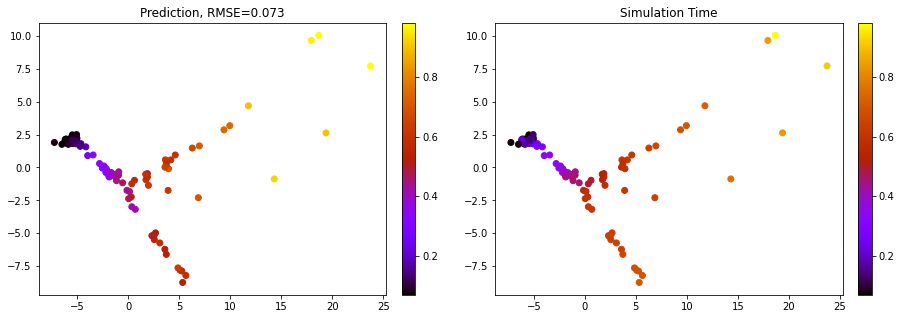

<Figure size 1080x360 with 0 Axes>

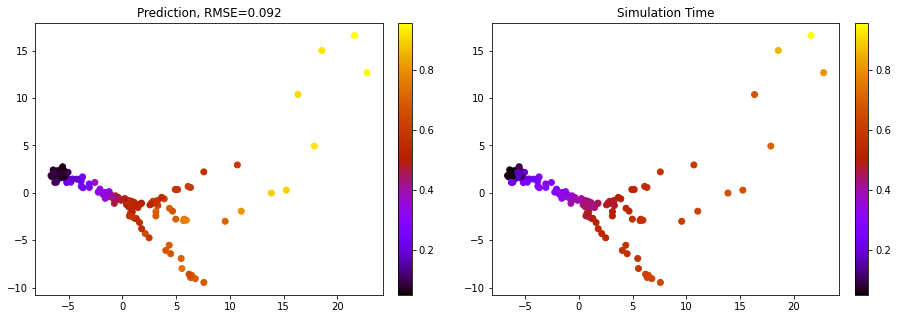

<Figure size 1080x360 with 0 Axes>

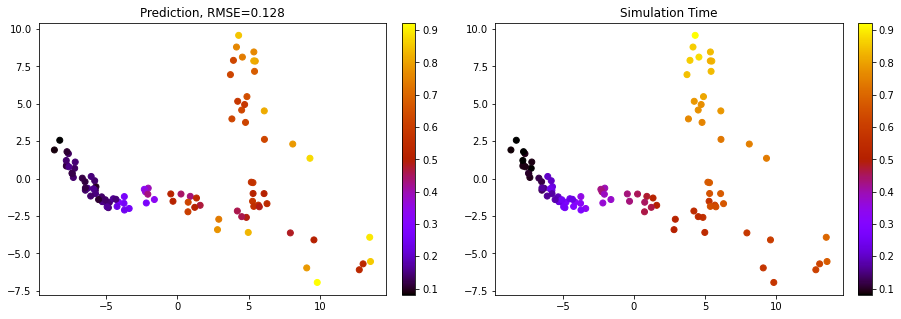

<Figure size 1080x360 with 0 Axes>

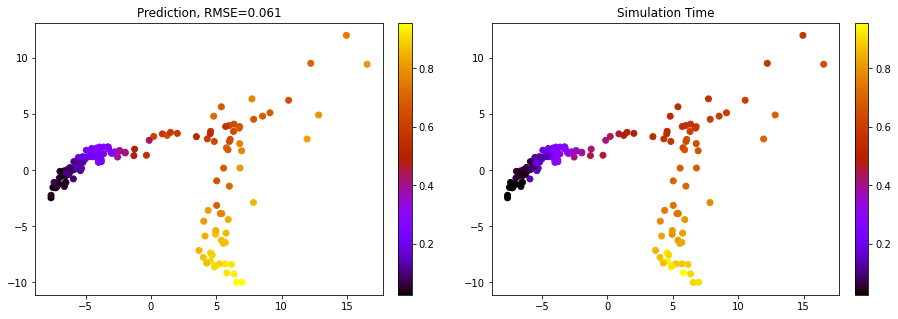

<Figure size 1080x360 with 0 Axes>

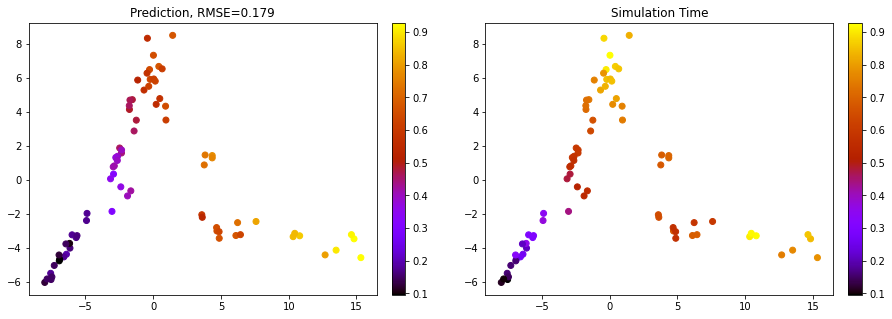

<Figure size 1080x360 with 0 Axes>

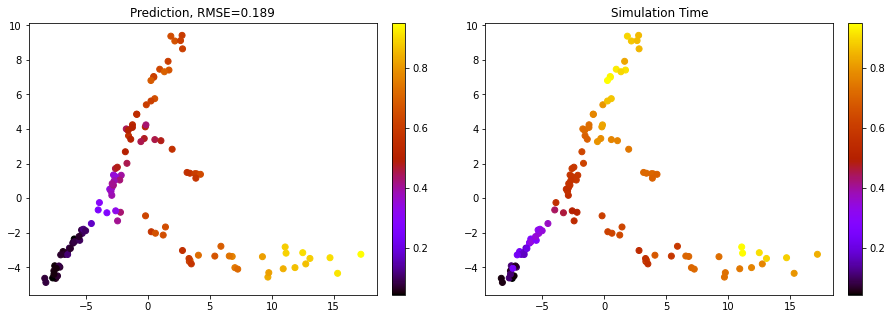

<Figure size 1080x360 with 0 Axes>

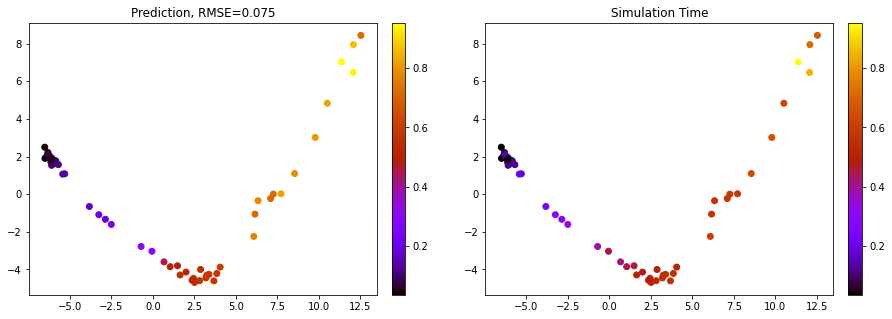

<Figure size 1080x360 with 0 Axes>

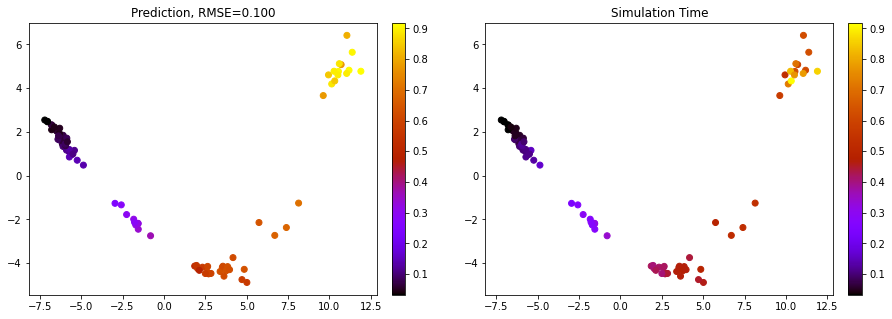

<Figure size 1080x360 with 0 Axes>

In [12]:
for data in val_loader:
    scatter(data)

## Adata List

In [13]:
adata_list = dataset.data.adata

## Slingshot

In [14]:
def slingshot_visual(adata, results, trajs = None, show_pcurve = True, figsize = (20,10), save_as = None):
    if trajs == None:
        trajs = results['pseudotime'].shape[1]
    ncols = np.ceil(trajs).astype('int32')
    nrows = 1
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    fig.suptitle("slingshot pseudo-time", fontsize = 18)
    for i in range(trajs):
        if nrows == 1 or ncols == 1:
            if nrows == 1 and ncols == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[i%nrows, i//nrows]
        ax.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1], color = 'gray', alpha = 0.1)
        if show_pcurve:
            # for curve in results['curves']:
            ax.plot(results['curves'][i,:,0],results['curves'][i,:,1],color = 'black')

        cells = results['pseudotime'].iloc[:,i]
        # eliminate `cell` in the string
        cells_index = [eval(x[4:])-1 for x in cells.index if not np.isnan(cells[x])]
        ordering = [eval(x[4:])-1 for x in cells[cells_index].sort_values().index]

        X_traj = adata.obsm['X_pca'][ordering,:]

        pseudo_visual = ax.scatter(X_traj[:,0],X_traj[:,1],c = np.arange(X_traj.shape[0]), cmap=plt.get_cmap('gnuplot'),alpha = 0.7)
        fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax)
        ax.set_title("reconstructed trajectory " + str(i))
    if save_as != None:
        fig.savefig(save_as)
    plt.show()     

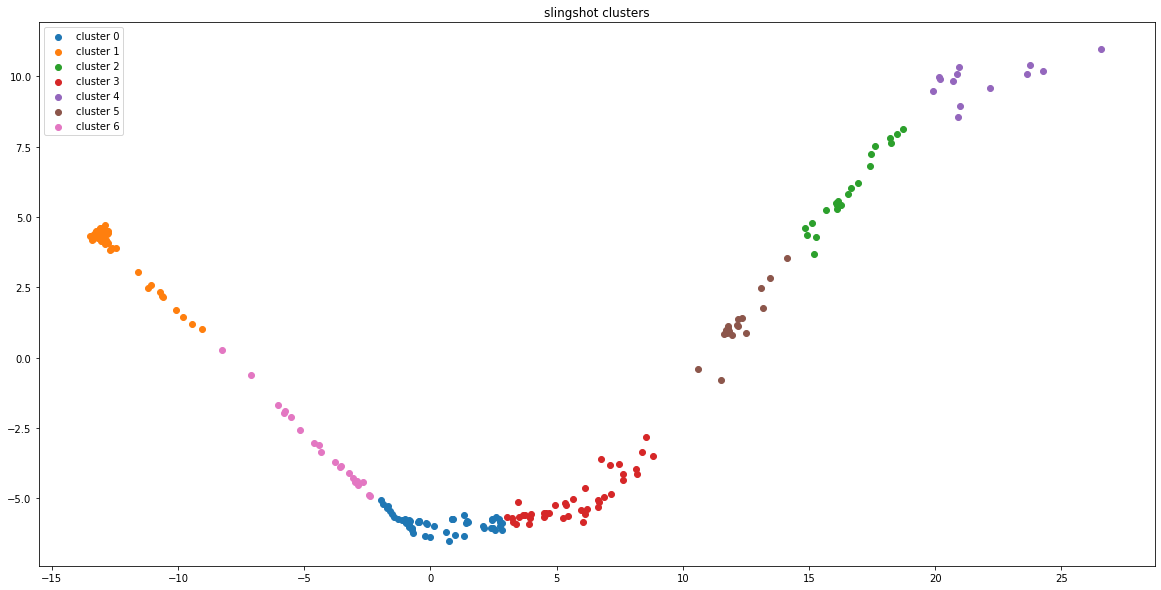

In [15]:
adata = adata_list[val_mask[0]]
X_pca = pca_op(adata.X.toarray(), n_comps = 2, standardize=False)
adata.obsm['X_pca'] = X_pca

from sklearn.cluster import KMeans
n_clusters = 7
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")

X_pca_df = pd.DataFrame(index=adata.obs.cell_id, columns= np.arange(X_pca.shape[1]), data = X_pca)
# scprep.run.install_bioconductor('slingshot')

In [16]:
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 2)
slingshot_visual(adata, results, trajs = None, show_pcurve = True, figsize = (20,10), save_as = None)

OSError: cannot load library 'C:\Program Files\R\R-4.0.0\bin\x64\R.dll': error 0x7e

## ScVelo latent time

recovering dynamics
... 100%    finished(0:00:11)-->added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing latent time
    finished(0:00:00)-->added 
    'latent_time', shared time (adata.obs)
GNN prediction order rmse: 40.48491076932244
Scvelo latent time order rmse: 53.99025838056343


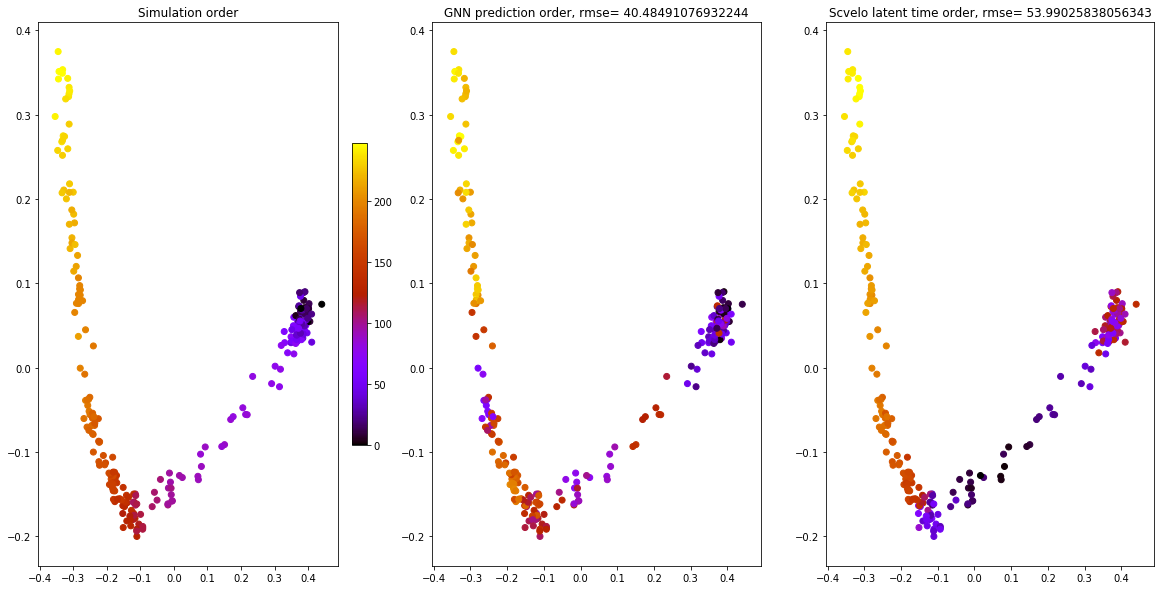

In [56]:
for i in val_mask:
    adata = adata_list[val_mask[0]]
    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.latent_time(adata)

    data = dataset[i]
    if isinstance(data.x, torch.Tensor):
        X_pca = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X_pca = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')

    data = data.to(device)
    pred = model(data).detach().cpu().numpy().reshape(-1)

    y_sorted = sorted(y)
    y_order = [y_sorted.index(i) for i in y]

    pred_sorted = sorted(pred)
    pred_order = [pred_sorted.index(i) for i in pred]
    gnn_rmse = sqrt(mean_squared_error(y_order, pred_order))
    print("GNN prediction order rmse: "+str(gnn_rmse))

    scvelo_sorted = sorted(adata.obs['latent_time'])
    scvelo_order = [scvelo_sorted.index(i) for i in adata.obs['latent_time']]
    scvelo_rmse = sqrt(mean_squared_error(y_order, scvelo_order))
    print("Scvelo latent time order rmse: " + str(scvelo_rmse))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.set_title("Simulation order")
    ax2.set_title("GNN prediction order, rmse= " + str(gnn_rmse))
    ax3.set_title("Scvelo latent time order, rmse= " + str(scvelo_rmse))
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y_order)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred_order)
    v3 = ax3.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=scvelo_order)
    
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    plt.show()
    break

In [54]:
print(adata.uns['recover_dynamics'])

{'fit_connected_states': False, 'fit_basal_transcription': None, 'use_raw': True}


## With KNN

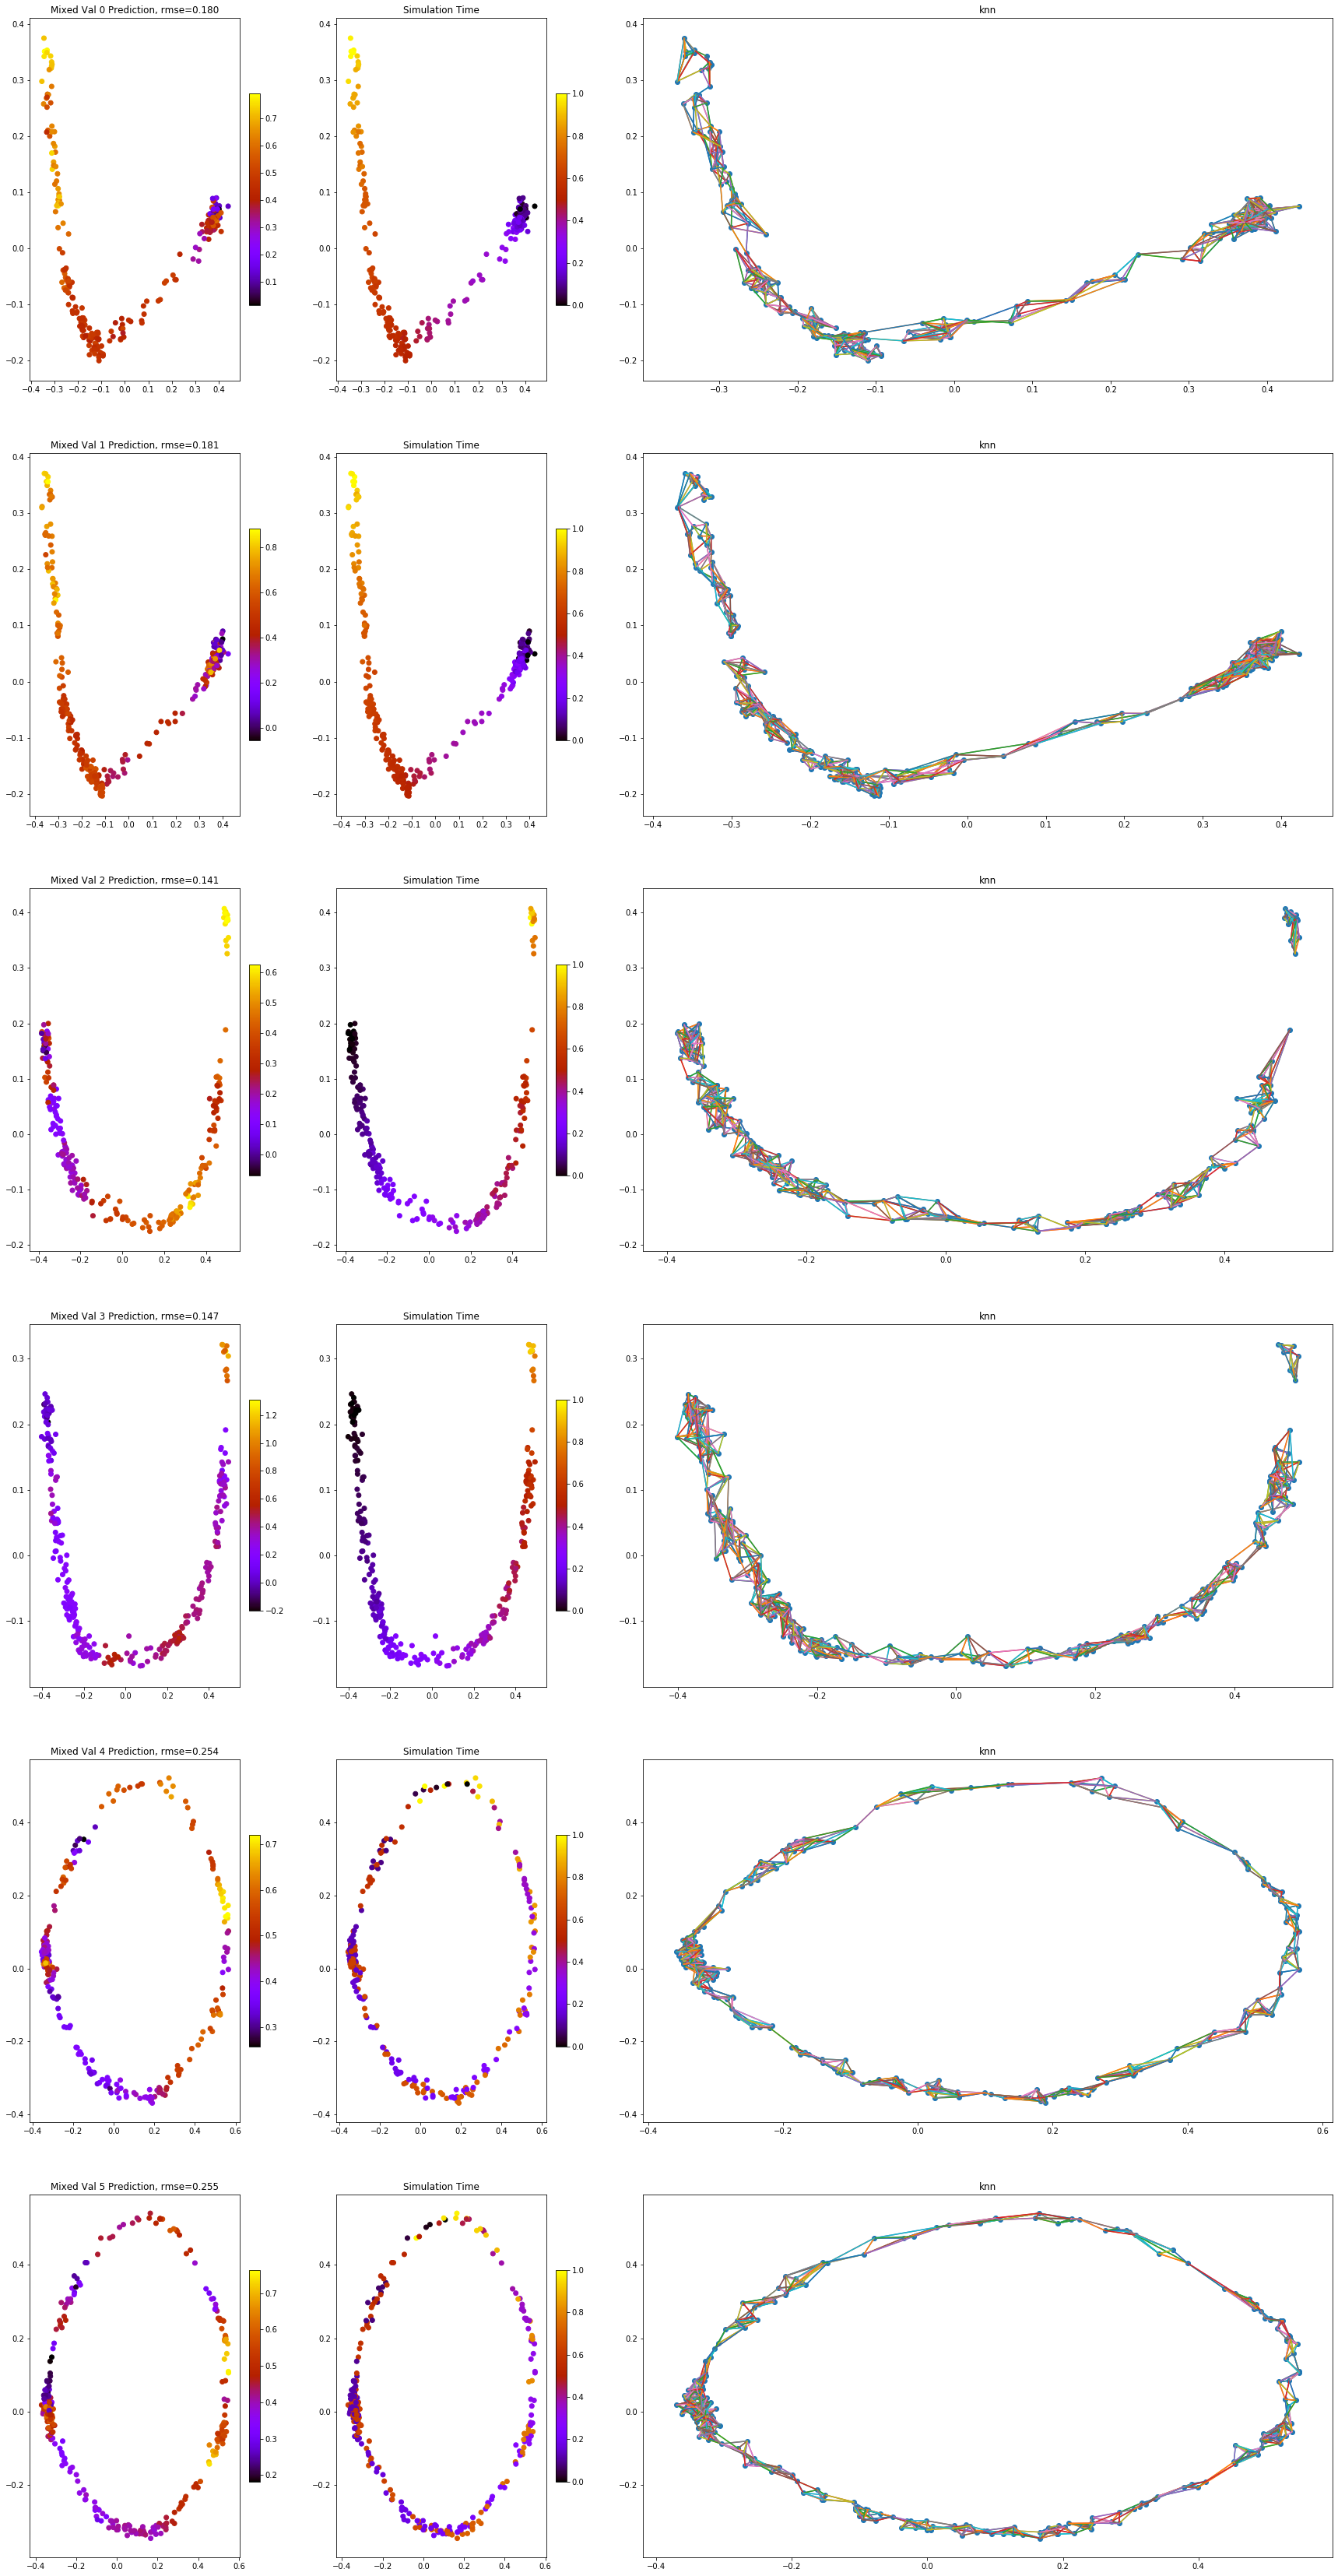

In [11]:
mask = val_mask
num_plot = len(mask)
fig, axs = plt.subplots(num_plot, 3, figsize=(30, 10*num_plot), gridspec_kw={'width_ratios': [1, 1, 3]})
for i in range(len(mask)):
    ax1, ax2, ax3 = axs[i]
    data = dataset[int(mask[i])]

    if isinstance(data.x, torch.Tensor):
        X_pca = data.x.numpy()
    elif isinstance(data.x, np.ndarray):
        X_pca = data.x
    else:
        raise ValueError('tensor or numpy array')
    
    if isinstance(data.y, torch.Tensor):
        y = data.y.numpy().squeeze()
    elif isinstance(data.y, np.ndarray):
        y = data.y
    else:
        raise ValueError('tensor or numpy array')

    edges = data.edge_index.numpy()

    pred = model(data.to(device)).detach().cpu().numpy().reshape(-1)
    rmse = sqrt(mean_squared_error(y, pred))

    prefix = "Mixed Val " + str(i)

    ax1.set_title(prefix + " Prediction, rmse=" + str(rmse)[:5])
    ax2.set_title("Simulation Time")
    ax3.set_title('knn')
    v1 = ax1.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=pred)
    fig.colorbar(v1, fraction=0.046, pad=0.04, ax = ax1)
    v2 = ax2.scatter(X_pca[:,0],X_pca[:,1], cmap = 'gnuplot', c=y)
    fig.colorbar(v2, fraction=0.046, pad=0.04, ax = ax2)

    ax3.scatter(X_pca[:,0], X_pca[:,1], cmap = 'gnuplot')
    for i in range(edges.shape[1]):
        ax3.plot(X_pca[edges[:,i]][:,0], X_pca[edges[:,i]][:,1])

plt.savefig("mymodel_visual/Mixed_val.png")
plt.show()

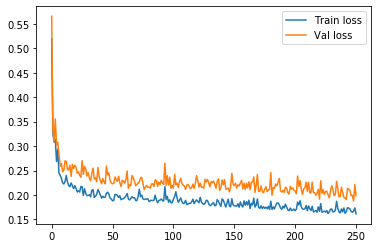

In [12]:
plt.plot(train_list)
plt.plot(val_list)
plt.legend(['Train loss', 'Val loss'])
plt.savefig('mymodel_visual/mymodel_loss.png')
plt.show()

In [15]:
backbones = ["bifurcating", "linear", "binary_tree", "trifurcating"]
seed = [1]
trans_rate = [3, 5, 10]
num_cells = [100, 150, 200, 250, 300]

root = '5_backbone/'

combined = [(bb, tr, nc) for bb in backbones for tr in trans_rate for nc in num_cells]
data_list = []

for item in combined:
    bb, tr, nc = item
    path = root + bb + "_" + str(tr) + "_1_1_" + str(nc)
    print(path)

    df = pd.read_csv(path + "_unspliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_unspliced = df.to_numpy()

    df = pd.read_csv(path + "_spliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_spliced = df.to_numpy()

    df = pd.read_csv(path + "_cell_info.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_obs = df

    adata = anndata.AnnData(X = csr_matrix(X_spliced),
                    obs = X_obs,
                    layers = dict(
                        unspliced = csr_matrix(X_unspliced),
                        spliced = csr_matrix(X_spliced)
                    ))

    scv.pp.filter_genes_dispersion(adata, n_top_genes = 72)
    adata = adata[:,:70]
    scv.pp.normalize_per_cell(adata)
    scv.pp.log1p(adata)

    X_spliced = adata.X.toarray()

    pca = PCA(n_components=30, svd_solver='arpack')
    # pipeline = Pipeline([('Standardize', StandardScaler()), ('pca', PCA(n_components=10, svd_solver='arpack'))])
    X_pca_ori = pca.fit_transform(X_spliced)
    print(pca.explained_variance_ratio_)

e/linear_5_1_1_150
Transforming to str index.
Normalized count data:X, spliced, unspliced.
[6.9831127e-01 1.9470002e-01 2.8106174e-02 1.7969396e-02 1.1200530e-02
 4.8523983e-03 3.7125654e-03 3.5011130e-03 2.9179149e-03 2.3455997e-03
 1.9759892e-03 1.7720720e-03 1.7349822e-03 1.5689021e-03 1.4955315e-03
 1.4011451e-03 1.3525781e-03 1.2620527e-03 1.2382475e-03 1.1085770e-03
 9.9849526e-04 9.6410414e-04 9.2671916e-04 8.6980377e-04 8.1320084e-04
 7.6140673e-04 7.3641638e-04 7.0615084e-04 6.6206965e-04 6.1009161e-04]
5_backbone/linear_5_1_1_200
Transforming to str index.
Normalized count data:X, spliced, unspliced.
[7.2582561e-01 1.5471625e-01 3.4794614e-02 2.3645636e-02 9.4402935e-03
 5.5243447e-03 3.8920941e-03 3.3719470e-03 3.1217777e-03 2.3468137e-03
 2.2137240e-03 1.8462880e-03 1.7110037e-03 1.6104090e-03 1.5183944e-03
 1.4599829e-03 1.3518491e-03 1.1782356e-03 1.1474530e-03 1.0715782e-03
 1.0246674e-03 1.0032064e-03 9.1730035e-04 8.6226821e-04 8.3203526e-04
 7.6657895e-04 7.1981235e-0